In [ ]:
# ============================
# 1 Importar bibliotecas
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline que suporta SMOTE


In [ ]:
# ============================
# 2 Ler dataset
# ============================
csv_path = 'StudentPerformanceFactors.csv'
df = pd.read_csv(csv_path)

# Visualizar primeiras linhas
df.head()


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [ ]:
# ============================
# 3 Criar variável alvo binária: Passed
# 1 → passou (nota >= 70)
# 0 → não passou
# ============================
df['Passed'] = (df['Exam_Score'] >= 70).astype(int)
df['Passed'].value_counts()


Passed
0    4982
1    1625
Name: count, dtype: int64

In [ ]:
# ============================
# 4 Selecionar features mais relevantes
# Escolhemos colunas que influenciam diretamente o desempenho
# ============================
X = df[['Hours_Studied', 'Motivation_Level', 'Teacher_Quality',
        'Attendance', 'Previous_Scores', 'Tutoring_Sessions']]
y = df['Passed']

# Separar colunas numéricas e categóricas
numeric_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions']
categorical_features = ['Motivation_Level', 'Teacher_Quality']

print("Colunas numéricas:", numeric_features)
print("Colunas categóricas:", categorical_features)


Colunas numéricas: ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions']
Colunas categóricas: ['Motivation_Level', 'Teacher_Quality']


In [ ]:
# ============================
# 5 Criar ColumnTransformer para pré-processamento
# - Numéricas: preencher missing (mediana) e escalar
# - Categóricas: preencher missing e One-Hot Encoding
# ============================
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [20]:
# ============================
# 6️⃣ Dividir treino e teste
# stratify=y mantém proporção de Passed=0 e Passed=1
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# ============================
# 7 Criar pipeline completo com SMOTE integrado
# - Pré-processamento + SMOTE + RandomForest
# ============================
clf = ImbPipeline([
    ('preprocessor', preprocessor),          # transforma numéricas e categóricas
    ('smote', SMOTE(random_state=42)),       # cria exemplos sintéticos da classe minoritária
    ('classifier', RandomForestClassifier(random_state=42))  # treina o modelo
])

# Treinar modelo
clf.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.91      0.92      0.91       997
           1       0.74      0.71      0.72       325

    accuracy                           0.87      1322
   macro avg       0.82      0.82      0.82      1322
weighted avg       0.87      0.87      0.87      1322



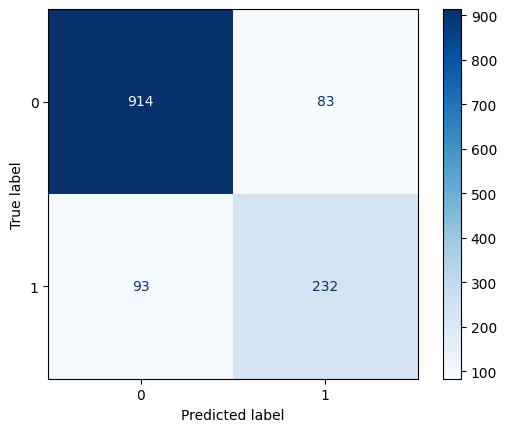

In [ ]:
# ============================
# 8 Prever no conjunto de teste
# Avaliar desempenho com métricas e matriz de confusão
# ============================
y_pred = clf.predict(X_test)

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.show()
